In [1]:
import pandas as pd
import pickle as pck
import matplotlib.pyplot as plt
import seaborn as sns
import ssaxgeo.MathToolBox as MathToolBox
import hdbscan
import numpy as np

In [2]:
# set input variables
grp_frag_df_flpath = "/home/antonio/Projects/HlxCnt/BC30/grp_frag_df_clust-30.p"
#grp_frag_df_flpath = "/home/antonio/Projects/HlxCnt/grp_frag_df_clust-90.p"

#grp_frag_df_flpath = "/home/ubuntu/Projects/git_stuff/SSAxgeo/grp_frag_df_clust-30.p"

save_dir = "./"
min_size = 4
# clustering parameters
min_cluster_size = 100
Pc_LIM = 0.4
## NOTES
# Export dataframe as csv on previous step

## Load dataframe

In [3]:
grp_frag_df = pck.load(open(grp_frag_df_flpath, 'rb')).drop(columns=[0,1])
## NOTES
# Do the drop of reduntant columns before exporting dataframe

In [4]:
len(grp_frag_df)

347994

In [5]:
def count_occurrences_above_threshold(arr, threshold_percentage=75):

    unique_elements, counts = np.unique(arr, return_counts=True)
    try:
        total_elements = len(arr)
    except(TypeError):
        return None
    # Calculate the occurrence percentages
    percentages = (counts / total_elements) * 100

    # Find elements with occurrence higher than the threshold
    result = unique_elements[percentages > threshold_percentage]

    if len(result) > 0:
        assert(len(result) == 1)
        return result.tolist()[0]
    else:
        return None

grp_frag_df["ss_major"] = grp_frag_df["ss"].apply(count_occurrences_above_threshold, threshold_percentage=75)

## Filtering fragments

In [6]:
print('@ Filtering fragments...')
print(f'  :: starting with {len(grp_frag_df)} fragments')
# 2.1 - Filter fragments
# 2.1.1- Remove extreme values
#print('  > removing extreme values...')
#t_max_cond = grp_frag_df['t_mean']<0.3#0.2
#t_min_cond = grp_frag_df['t_mean']>-0.3
#w_max_cond = grp_frag_df['w_mean']<0.3
#w_min_cond = grp_frag_df['w_mean']>-0.3
#grp_fdf_1 = grp_frag_df.loc[t_max_cond & t_min_cond & w_max_cond & w_min_cond]
#print('  :: ', len(grp_fdf_1), ' fragments remaining')

# filter by size
print(f'  > removing fragments less than {min_size} residues...')
min_size_cond = grp_frag_df["size"] >= min_size
grp_fdf_1 = grp_frag_df.loc[min_size_cond]
print('  :: ', len(grp_fdf_1), ' fragments remaining')

#grp_fdf_1.to_csv(save_dir+"/filtered_frags_1.csv")

#grp_fdf_2.to_csv(save_dir+"/filtered_frags_2.csv")

#print('  > removing fragments with high standard deviations...')
#c_std_cond = grp_fdf_1['c_std'] <= 0.07
#t_std_cond = grp_fdf_1['t_std'] <= 0.01
#grp_fdf_2 = grp_fdf_1.loc[c_std_cond & t_std_cond]
#print('  :: ', len(grp_fdf_2), ' fragments remaining')
#grp_fdf_3.to_csv(save_dir+"/filtered_frags_3.csv")


@ Filtering fragments...
  :: starting with 347994 fragments
  > removing fragments less than 4 residues...
  ::  204910  fragments remaining


## Explore data

### Check size to standard deviation distribution

(0.0, 0.1)

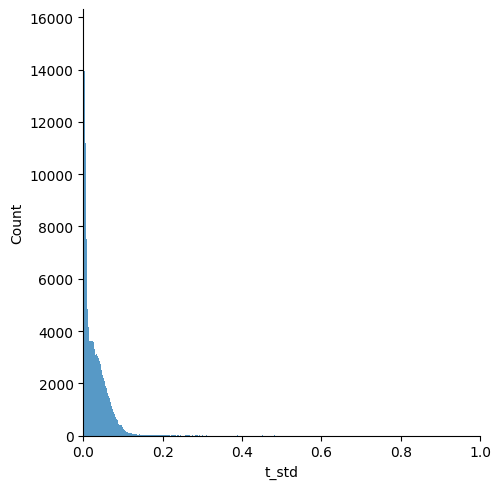

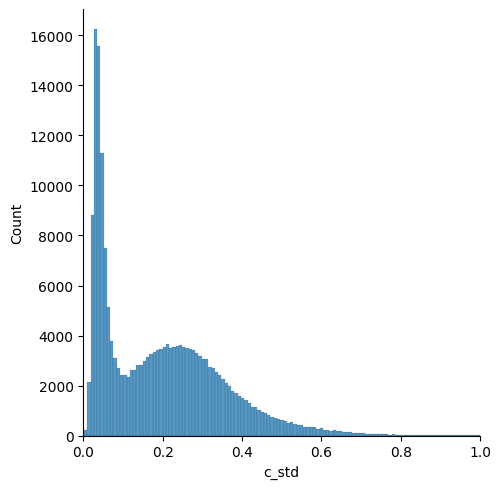

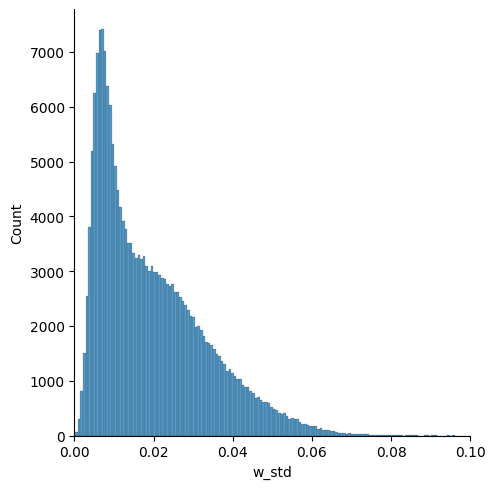

In [7]:
sns.displot(grp_fdf_1["t_std"])
plt.xlim(0,1)

sns.displot(grp_fdf_1["c_std"])
plt.xlim(0,1)

sns.displot(grp_fdf_1["w_std"])
plt.xlim(0,0.1)


(0.0, 1.0)

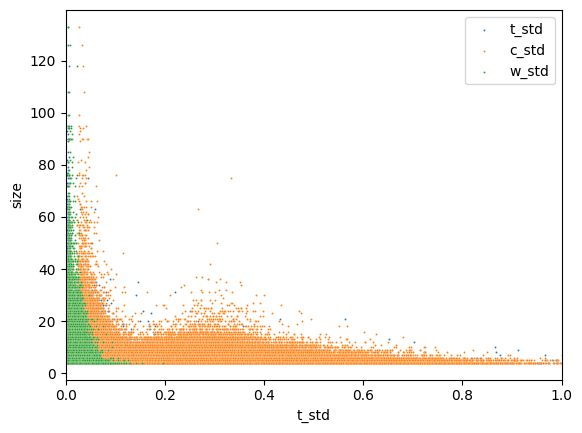

In [8]:
sns.scatterplot(data=grp_fdf_1, x="t_std", y="size", s=2, label="t_std")
sns.scatterplot(data=grp_fdf_1, x="c_std", y="size", s=2, label="c_std")
sns.scatterplot(data=grp_fdf_1, x="w_std", y="size", s=2, label="w_std")
plt.xlim(0,1)


(0.0, 0.2)

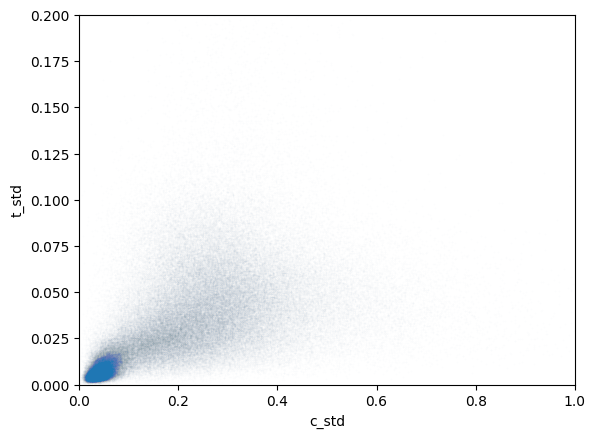

In [9]:
sns.scatterplot(data=grp_fdf_1, x="c_std", y="t_std", alpha=0.01, s=2)
#sns.scatterplot(data=grp_fdf_1, x="c_std", y="size", s=2, label="c_std")
#sns.scatterplot(data=grp_fdf_1, x="w_std", y="size", s=2, label="w_std")
plt.xlim(0,1)
plt.ylim(0, 0.2)

### FILTER BY STD

  > removing fragments with high standard deviations...
  ::  76377  fragments remaining
128533


(-0.2, 0.2)

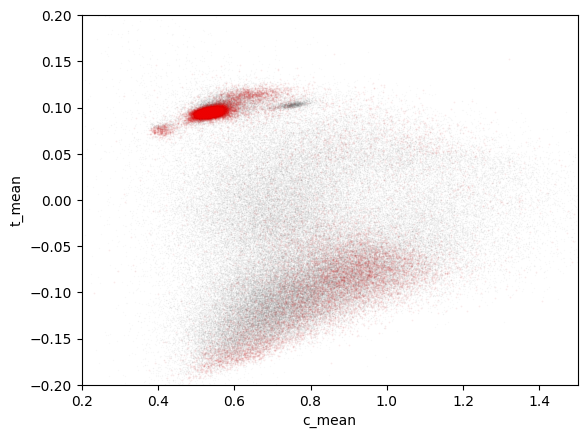

In [10]:
# test std filters
print('  > removing fragments with high standard deviations...')
#c_std_cond = grp_fdf_1['c_std'] <= 0.1
#t_std_cond = grp_fdf_1['t_std'] <= 0.1
# paper tresholds
c_std_cond = grp_fdf_1['c_std'] <= 0.55
t_std_cond = grp_fdf_1['t_std'] <= 0.015

grp_fdf_new = grp_fdf_1.loc[c_std_cond & t_std_cond]
print('  :: ', len(grp_fdf_new), ' fragments remaining')
print(len(grp_fdf_1) - len(grp_fdf_new))

sns.scatterplot(data=grp_fdf_1, x="c_mean", y="t_mean", s=1, alpha=0.05, c="grey")
sns.scatterplot(data=grp_fdf_new, x="c_mean", y="t_mean", s=2, alpha=0.05, c="red")
plt.xlim(0.2,1.5)
plt.ylim(-0.2,0.2)


## Check strange cluster

(0.08, 0.11)

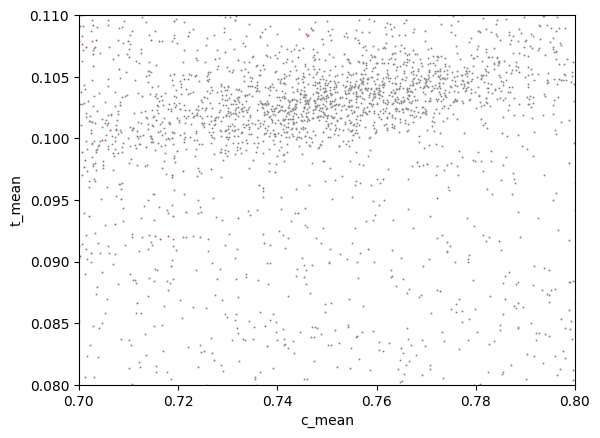

In [16]:
sns.scatterplot(data=grp_fdf_1, x="c_mean", y="t_mean", s=2, alpha=1, c="grey")
sns.scatterplot(data=grp_fdf_new, x="c_mean", y="t_mean", s=1, alpha=0.5, c="red")
plt.xlim(0.7,0.8)
plt.ylim(0.08,0.11)

In [17]:
strange_cluster_region = grp_fdf_1.loc[(grp_fdf_1["c_mean"]>0.7) & (grp_fdf_1["c_mean"]<0.8) & (grp_fdf_1["t_mean"] > 0.09) & (grp_fdf_1["t_mean"]<0.1)][["ss", "ss_major"]]
strange_cluster_region.to_csv(save_dir+"strange_cluster_region_30.csv")

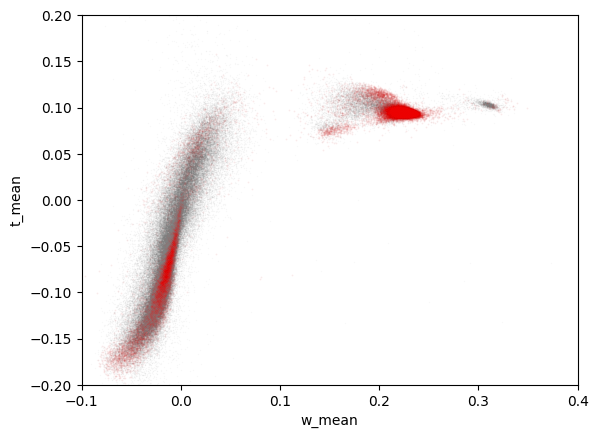

In [21]:
sns.scatterplot(data=grp_fdf_1, x="w_mean", y="t_mean", s=1, alpha=0.05, c="grey")
sns.scatterplot(data=grp_fdf_new, x="w_mean", y="t_mean", s=2, alpha=0.05, c="red")
plt.xlim(-0.1,0.4)
plt.ylim(-0.2,0.2)
plt.savefig(save_dir+"filtered_by_std_30.png", dpi=300)

## Check DSSP majority states distributions

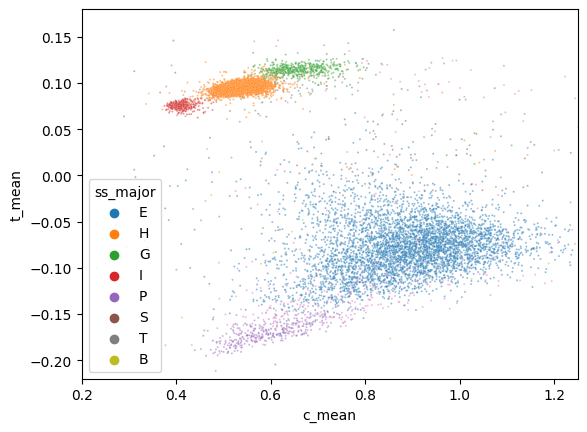

In [24]:
sns.scatterplot(data=grp_fdf_new, x="c_mean", y="t_mean", s=2, alpha=0.5,hue="ss_major")
plt.xlim(0.2,1.25)
plt.ylim(-0.22,0.18)
plt.savefig(save_dir+"ss_major_dist_kt_30.png", dpi=300)

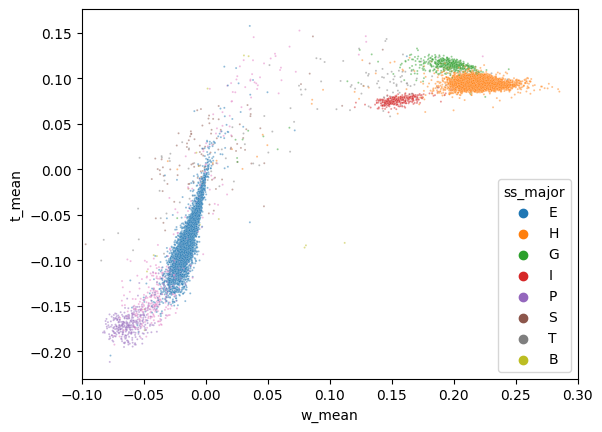

In [25]:
sns.scatterplot(data=grp_fdf_new, x="w_mean", y="t_mean", s=2, alpha=0.5,hue="ss_major")
plt.xlim(-0.1,0.3)
#plt.ylim(-0.5,0.4)
plt.savefig(save_dir+"ss_major_dist_wt_30.png", dpi=300)

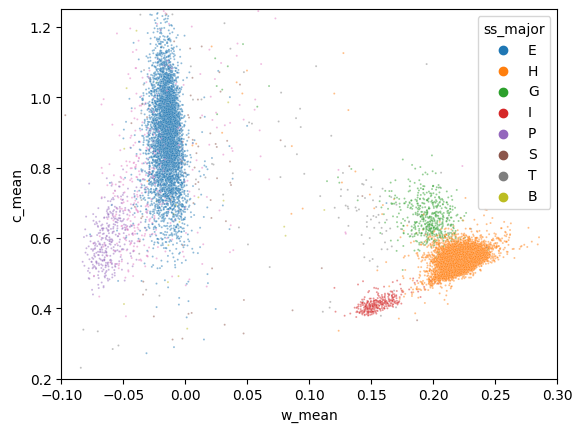

In [26]:
sns.scatterplot(data=grp_fdf_new, x="w_mean", y="c_mean", s=2, alpha=0.5,hue="ss_major")
plt.xlim(-0.1,0.3)
plt.ylim(0.2,1.25)
plt.savefig(save_dir+"ss_major_dist_wc_30.png", dpi=300)

# Clustering

In [27]:
def cluster_grp_frags(frag_df, max_d=1.0, show_plot=False,
    cols = ['c_mean', 'w_mean', 't_mean'], method='kmeans', **cls_kwargs):
    '''Recluster group fragment dataframe.'''
    #TODO add sanity check
    VALID_METHODS = ['kmeans', 'hdbscan', 'hierarc']
    assert(method in VALID_METHODS), '{} not supported'.format(method)

    # get data to cluster
    #vld_frag_df = self.grp_frag_df[cols]
    vld_frag_df = frag_df[cols]

    if method == 'hierarc':
            # TODO improve kwargs handling, instead of using a default value
            #      maybe will be better to let the user have more control
            max_d = cls_kwargs.get('max_d', 1.0)
            # Calculate linkage matrix
            Z = MathToolBox.get_linkage_mtx_of(vld_frag_df)

            # get clusters assignment array
            clusters = fcluster(Z, max_d, criterion='distance')

            # generate plots
            if show_plot is True:
                MathToolBox.fancy_dendrogram(Z,
                    truncate_mode='lastp', p=12,# show only the last p merged clusters
                    leaf_rotation=90.,
                    leaf_font_size=12.,
                    show_contracted=True,
                    annotate_above=0.1,  # useful in small plots so annotations don't overlap
                    max_d=max_d)

    if method == 'kmeans':
            # clustering specific arguments
            err_msg = 'n_clusters = <int> must be provided for kmeans'
            assert('n_clusters' in cls_kwargs), err_msg

            n_clusters = cls_kwargs['n_clusters']
            random_state = cls_kwargs.get('random_state', 0)
            n_jobs= cls_kwargs.get('n_jobs', 1)

            # do the clustering
            clusters = MathToolBox.run_kmeans_at(vld_frag_df,
                        n_clusters, random_state=random_state, n_jobs=n_jobs)

    if method == 'hdbscan':
            # got clustering arguments
            min_cluster_size = cls_kwargs['min_cluster_size']
            do_soft = cls_kwargs.get('do_soft', True)
            use_distMTX = cls_kwargs.get('use_distMTX', False)
            allow_single_cluster=cls_kwargs.get('allow_single_cluster', True)

            # do the clustering
            clusterer = MathToolBox.do_hdbscan_at(vld_frag_df,
                            min_cluster_size,do_soft=do_soft,
                            use_distMTX=use_distMTX,
                            allow_single_cluster=allow_single_cluster)
            clusters = clusterer.labels_

    ### NOTE ###########################################################
    ## for the future, add clusters probabilities for soft clustering
    ####################################################################

    # add clustering results column to group fragments dataframe
    cluster_col = pd.DataFrame(clusters, columns=['grp_frag_clusters'],
                               index=vld_frag_df.index)
    final_df = pd.concat([frag_df, cluster_col], axis=1)
    if method == 'hdbscan' and do_soft == True:
            return final_df, clusterer
    else:
            return final_df


def get_core_labels(df, Pc_LIM):
    '''
    Check if a residue belongs to the 'core' of the cluster.
    The core points in a cluster are consider each an every point which the
    membership probability is greater than a specified limit (default=0.60).
    '''
    def _check_prob(row):
        Pc_max = np.array(row['membership_vec']).max()
        if Pc_max >= Pc_LIM:
            return True
        else:
            return False

    return df.apply(_check_prob, axis=1)



We could just use the `SS_major` to identify the clusters, however, I want to see if we could recover the SS just based on the density of the regions geometrical helices occurs without having to rely on DSSP. Unfortunately, the alpha helices are so much denser than the other regions, which make it hard for density based clustering algorithms to consider the \$3_{10}\$ helix its own cluster when the whole data is considered. To solve this we will split the data based on Writhing Number, on Alpha/Pi/3(10) and PP2 regions.

## Alpha/Pi/3(10) canonical regions

|---------| Alpha/Pi/3(10) canonical region |---------|
@ clustering |w| > 0.1...
   > filtering 
  :: 67695 frags after filtering


(0.05, 0.15)

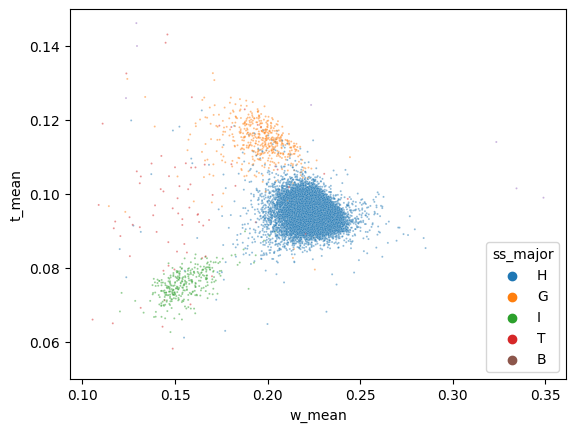

In [39]:

print('|---------| Alpha/Pi/3(10) canonical region |---------|')
# generate clusters for Pi, Alpha and 3(10)
#   Pi, Alpha and 3(10) helices residues belongs to the region of |w| > 0.1 and
# those  usually forms globular clusters. The strategy for those SSE is:
print('@ clustering |w| > 0.1...')
print('   > filtering ')
wgrtr_1 = grp_fdf_new['w_mean'] >  0.1

# remove E and S regions
non_E = grp_fdf_new["ss_major"] != "E"
non_S = grp_fdf_new["ss_major"] != "S"

ss_H = grp_fdf_new["ss_major"] == "H"
ss_I = grp_fdf_new["ss_major"] == "I"
ss_G = grp_fdf_new["ss_major"] == "G"

ss_T = grp_fdf_new["ss_major"] == "T"
ss_B = grp_fdf_new["ss_major"] == "B"
ss_P = grp_fdf_new["ss_major"] == "P"


df_AP3 = grp_fdf_new.loc[non_E & non_S & wgrtr_1]# & (wgrtr_2)]

print(f'  :: {len(df_AP3)} frags after filtering')

sns.scatterplot(data=df_AP3, x="w_mean", y="t_mean", s=2, alpha=0.5,hue="ss_major")
plt.ylim(0.05,0.15)

(0.05, 0.15)

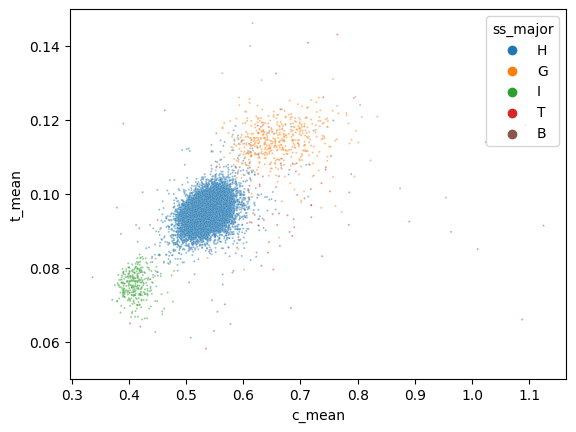

In [41]:
sns.scatterplot(data=df_AP3, x="c_mean", y="t_mean", s=2, alpha=0.5,hue="ss_major")
plt.ylim(0.05,0.15)

In [47]:
# run hdbscan
min_cluster_size = 50 #25
# -----------------------------------------------------------------
# NOTE: using min_cluster_size = 25 you get an extra cluster which 
#       its meaning is not clear to me. It could be nothing, but 
#       it worths to check.
# ----------------------------------------------------------------
print('  > running hdbscan [min_cluster_size=',min_cluster_size,']...')

df_1_2, clusterer = cluster_grp_frags(df_AP3,
                                    cols = ['c_mean', 'w_mean', 't_mean'], method='hdbscan',
                                    min_cluster_size=min_cluster_size)


# Compute the membership vectors for the clustering assignment
print('  > computing membership vectors...')
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
df_1_2['membership_vec'] = tuple(soft_clusters)
print("  > clusters found:")
print(df_1_2["grp_frag_clusters"].unique())


  > running hdbscan [min_cluster_size= 50 ]...
  > computing membership vectors...
  > clusters found:
[ 2 -1  0  1]


<AxesSubplot: xlabel='c_mean', ylabel='t_mean'>

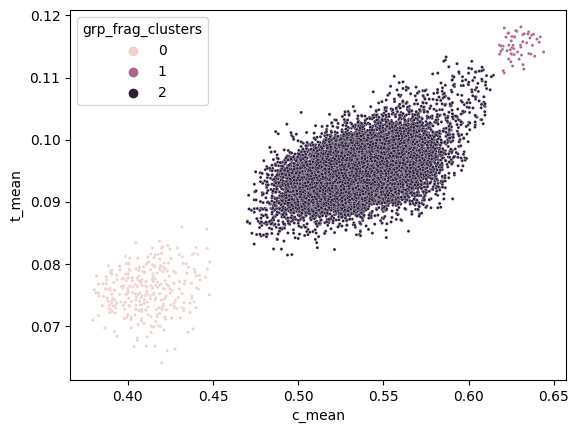

In [48]:
sns.scatterplot(data=df_1_2.loc[~ (df_1_2["grp_frag_clusters"] == -1)], x='c_mean', y='t_mean', hue='grp_frag_clusters', s=5)#df_1_2
#sns.scatterplot(data=df_1_2.loc[(df_1_2["grp_frag_clusters"] == -1)], x='c_mean', y='t_mean', hue='grp_frag_clusters', s=.5)#df_1_2


## Automatically determinate the labels

In [59]:
# Determinate labels
clusters = df_1_2["grp_frag_clusters"].unique()

label_dct = {}
for c in clusters:
    if c == -1:
        continue
    ss_counts_dct = df_1_2.loc[df_1_2["grp_frag_clusters"] == c]["ss_major"].value_counts().to_dict()
    higher_count = 0
    label = None
    for k in ss_counts_dct:
        if ss_counts_dct[k] > higher_count:
            higher_count = ss_counts_dct[k]
            label = k
    label_dct[label] = c

    print(label_dct)

{'H': 2, 'I': 0, 'G': 1}


## Check helices on the clusters

In [62]:
cols = ["pdbid","chain","res_start","res_final","ss", "ss_major"]
df_1_2.loc[df_1_2["grp_frag_clusters"] == 0][cols]

,pdbid,chain,res_start,res_final,ss,ss_major
686,8add,A,487,490,"[I, I, I, I]",I
1426,8ec3,A,284,288,"[I, I, I, I, I]",I
1587,4lrs,A,268,272,"[I, I, I, I, I]",I
3231,1q8i,A,226,229,"[I, I, I, I]",I
3248,1q8i,A,753,757,"[I, I, I, I, I]",I
...,...,...,...,...,...,...
337329,6pal,B,253,258,"[I, I, I, I, I, I]",I
337521,6ptm,A,451,454,"[I, I, I, I]",I
344882,7k34,A,340,344,"[I, I, I, I, I]",I
345066,7kmm,B,408,411,"[H, H, H, T]",None


In [64]:
df_1_2.loc[df_1_2["grp_frag_clusters"] == 1][cols]

,pdbid,chain,res_start,res_final,ss,ss_major
2333,2ibt,D,318,321,"[G, G, G, G]",G
8822,1dm1,A,38,42,"[G, G, G, G, G]",G
10622,2c5q,E,227,231,"[H, G, G, G, G]",G
17773,3nft,A,1168,1171,"[G, G, G, G]",G
21008,4eoi,D,318,321,"[H, H, T, T]",None
30163,4hb2,C,47,51,"[G, G, G, G, H]",G
30464,1w07,B,276,279,"[T, T, H, H]",None
32068,2omz,A,334,337,"[G, G, G, G]",G
36144,4zil,B,123,128,"[G, G, G, G, G, G]",G
40356,3ss9,X,249,252,"[H, T, H, H]",None


In [ ]:
# AP3 is Done, we have the canonicals!
# TODO check if working with just the core members is necessary
# TODO do the same for PP2
# TODO test the follow up (classify residues according to canonicals)
# TODO check results presented on the paper

In [ ]:
Pc_LIM = 0.4
# 4.3) Determinate which points belongs to the core of the clusters
print(f'  > selecting data points belonging to clusters core (Pc_lim = {Pc_LIM})...')
df_1_2['is_at_core'] = get_core_labels(df_1_2, Pc_LIM=Pc_LIM)
print(df_1_2[['membership_vec','is_at_core']])
core_df = df_1_2.loc[df_1_2['is_at_core']==True]

In [ ]:
sns.scatterplot(data=df_1_2, x="c_mean", y="t_mean", s=2, alpha=0.5,label="df_1_2", c="grey")
sns.scatterplot(data=core_df, x="c_mean", y="t_mean", s=2, alpha=0.5,label="core_df", c="blue")


In [ ]:
# final cluster
print('  :: ', len(core_df), 'total fragments selected' )
print(np.unique(core_df['grp_frag_clusters'], return_counts=True))
sns.scatterplot(data=core_df, x="c_mean", y="t_mean", hue="grp_frag_clusters", s=2, alpha=0.5, c="blue")

#grp_df_wgrtr.to_csv(save_dir+"/grp_df_wgrtr.csv")
#print('   > saving core dataframes at ', save_dir,'...')


In [ ]:
core_df.loc[core_df["grp_frag_clusters"] == 3][["pdbid", "c_mean", "t_mean", "ss"]]

## PP2 helix

# CANONICAL

In [ ]:
cols_order = ['pdbid','chain','kind','res_start','res_final','size','seq','ss',
              'c_mean','c_std','c_std_s','label','cluster','cs_mean',
              'hn1_A_mean',      'hn1_A_median',         'hn1_A_std',
              'hn1_A_vals',       'hn1_en_mean',     'hn1_en_median',
              'hn1_en_std',       'hn1_en_vals',        'hn2_A_mean',
            'hn2_A_median',         'hn2_A_std',        'hn2_A_vals',
             'hn2_en_mean',     'hn2_en_median',        'hn2_en_std',
             'hn2_en_vals',        'ho1_A_mean',      'ho1_A_median',
               'ho1_A_std',        'ho1_A_vals',       'ho1_en_mean',
           'ho1_en_median',        'ho1_en_std',       'ho1_en_vals',
              'ho2_A_mean',         'ho2_A_std',        'ho2_A_vals',
             'ho2_en_mean',     'ho2_en_median',        'ho2_en_std',
             'ho2_en_vals',            't_mean',
                   't_std',           't_std_s',           'ts_mean',
                  'w_mean',             'w_std',           'wr_mean',
                  'wr_std',
       'grp_frag_clusters']

In [ ]:
# load canonical dfs
can_dir = "/home/ubuntu/Projects/git_stuff/SSAxgeo/canonical/"
alpha_df=pck.load(open(f"{can_dir}alpha_can.p", "rb"))
alpha_df.drop([0,1], axis=1, inplace=True)
#alpha_df.rename(columns={0:"pdbid", 1:"chain"}, inplace=True)
alpha_df[cols_order].to_csv(f"{can_dir}alpha_can.csv", index=False)

pi_df=pck.load(open(f"{can_dir}pi_can.p", "rb"))
pi_df.drop([0,1], axis=1, inplace=True)
#pi_df.rename(columns={0:"pdbid", 1:"chain"}, inplace=True)
pi_df[cols_order].to_csv(f"{can_dir}pi_can.csv", index=False)

three_df=pck.load(open(f"{can_dir}three_can.p", "rb"))
three_df.drop([0,1], axis=1, inplace=True)
#three_df.rename(columns={0:"pdbid", 1:"chain"}, inplace=True)
three_df[cols_order].to_csv(f"{can_dir}three_can.csv", index=False)

pp2_df=pck.load(open(f"{can_dir}pp2_can.p", "rb"))
#pp2_df.rename(columns={0:"pdbid", 1:"chain"}, inplace=True)
pp2_df.drop([0,1], axis=1, inplace=True)
pp2_df["label"] = "pp2"
pp2_df[cols_order].to_csv(f"{can_dir}pp2_can.csv", index=False)

In [ ]:
alpha_df.columns

In [ ]:
all_canonical = pd.concat([alpha_df,pi_df,three_df,pp2_df], ignore_index=True)

#all_canonical[[0,1]]#.columns

In [ ]:
sns.scatterplot(data=all_canonical, x='c_mean', y='t_mean', hue='label', s=5)#df_1_2


In [ ]:
sns.scatterplot(data=all_canonical, x='w_mean', y='t_mean', hue='label', s=5)#df_1_2


In [ ]:
three_df[cols_order].loc[three_df["size"]>4]#[["t_mean","ts_mean"]]

# COMPARE FLEXGEO TO MELODIA


In [ ]:
flx_path = "/home/ubuntu/Projects/git_stuff/SSAxgeo/3zp7_C_flxgeo.csv"
mel_path = "/home/ubuntu/Projects/git_stuff/SSAxgeo/3zp7_C_xdata_df.csv"
dgo_path = "/home/ubuntu/Projects/git_stuff/SSAxgeo/3zp7_C.csv"

flx_cols = ["conf", "res", "curv", "tor", "arc","wri", "ca_x", "ca_y", "ca_z","res_name"]
flx_df = pd.read_csv(flx_path, names=flx_cols)

mel_df = pd.read_csv(mel_path)

dgo_cols = ["conf","res_name","atom", "res", "curv", "tor", "wri","arc"]
dgo_df = pd.read_csv(dgo_path, names=dgo_cols)

In [ ]:
print(f"{len(dgo_df)}| {len(flx_df)} | {len(mel_df)}")

In [ ]:
(flx_df["curv"] - mel_df["curv"] ).values

In [ ]:
sns.lineplot((flx_df["curv"] - dgo_df["curv"]), label=r"$dD$")
sns.lineplot((flx_df["curv"] - mel_df["curv"]), label=r"$dM$")



In [ ]:
sns.lineplot((flx_df["tor"] - dgo_df["tor"]), label=r"$dD$")
sns.lineplot((flx_df["tor"] - mel_df["tor"]), label=r"$dM$")

In [ ]:
sns.lineplot((flx_df["wri"] - dgo_df["wri"]), label=r"$dD$")
sns.lineplot((flx_df["wri"] - mel_df["wri"]), label=r"$dM$")

In [ ]:
# TODO MIGRATE CODE TO DIFFGEO OR FLEXGEO